# Credit Risk Forecasting Lending Club Data

- Lending dataset obtained from [Lending Club](https://www.lendingclub.com/)
- Lending dataset included current load status (Current, Late, Fully Paid) and a large set of attributes per customer
- Dataset is heavily imbalanced with "good loans" target

In [257]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 
from copy import deepcopy
import random

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# For ML Models
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression

# For Accuracy Metrices
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Feature Selection
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

from info_gain import info_gain

from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

from collections import defaultdict
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [66]:
df = pd.read_csv("./LendingClub.csv")

In [67]:
df.head()

,acc_now_delinq,acc_open_past_24mths,all_util,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_amnt,...,total_cu_tl,total_il_high_credit_limit,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,delinq_2yrs,bad_loans
0,0.0,3.0,1.0,52000.0,25099.0,30359.0,0.5,0.0,0.0,0.0,...,2.0,0.0,3011.577285,3011.58,11.58,0.0,3000.0,31000.0,0.0,0
1,0.0,2.0,47.0,55000.0,2222.0,10551.0,52.0,0.0,0.0,0.0,...,1.0,27751.0,5013.306667,5013.31,13.31,0.0,5000.0,33800.0,0.0,0
2,0.0,3.0,86.0,51000.0,4541.0,2498.0,0.1,0.0,0.0,0.0,...,0.0,24001.0,1032.903619,1032.90,32.90,0.0,1000.0,2500.0,0.0,0
3,0.0,2.0,41.0,62000.0,18520.0,18310.0,51.2,0.0,0.0,0.0,...,0.0,21976.0,20009.805556,19984.79,9.81,0.0,20000.0,39500.0,0.0,0
4,0.0,11.0,60.0,30000.0,5990.0,7898.0,7.1,0.0,0.0,0.0,...,5.0,62319.0,24334.736554,24334.74,334.74,0.0,24000.0,12000.0,0.0,0


## Rebalancing Data ##
- via Oversampling method to account for lack of "bad loans"

In [68]:
# Update our features and output
df_bal = deepcopy(df) # Please note the difference between shallow copy and deep copy in Python
df_bal.dropna(inplace=True) # Drop missing values

# Address Unbalanced data: Oversampling
# You may need to set seed first, otherwise if you use different training data to train the model, you will get different tree model
random.seed(1234)

# Class count
count_class_0, count_class_1 = df_bal['bad_loans'].value_counts()

# Divide by class
df_class_0 = df_bal[df_bal['bad_loans'] == 0]
df_class_1 = df_bal[df_bal['bad_loans'] == 1]

# Address unblanced data issue: Oversampling on data samples with rare outputs (which is '1' in this example)
df_class_1_over = df_class_1.sample(count_class_0, replace=True, random_state=1234)
df_bal = pd.concat([df_class_1_over, df_class_0], axis=0)

df_bal.reset_index(inplace = True)

In [69]:
df_bal['bad_loans'].value_counts()

1    2516
0    2516
Name: bad_loans, dtype: int64

In [70]:
df_bal.dtypes.value_counts()

float64    70
int64       2
dtype: int64

In [71]:
# Number of unique classes in each object column
# Differentiate categoical and numerical 
numerical = df_bal.apply(pd.Series.nunique, axis = 0)[df_bal.apply(pd.Series.nunique, axis = 0).values>10].index
categorical = df_bal.apply(pd.Series.nunique, axis = 0)[df_bal.apply(pd.Series.nunique, axis = 0).values<=10].index
numerical = [i for i in numerical if i != 'index']
categorical = [i for i in categorical if i != 'bad_loans']

In [72]:
 df_bal.apply(pd.Series.nunique, axis = 0)[df_bal.apply(pd.Series.nunique, axis = 0).values<=10]

acc_now_delinq                2
chargeoff_within_12_mths      3
collections_12_mths_ex_med    3
delinq_amnt                   6
inq_last_6mths                6
num_tl_30dpd                  2
num_tl_90g_dpd_24m            9
open_il_12m                   7
pub_rec_bankruptcies          4
tax_liens                     6
bad_loans                     2
dtype: int64

In [73]:
numerical

['acc_open_past_24mths',
 'all_util',
 'annual_inc',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'dti',
 'inq_fi',
 'inq_last_12m',
 'installment',
 'int_rate',
 'last_pymnt_amnt',
 'loan_amnt',
 'max_bal_bc',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_last_delinq',
 'mths_since_rcnt_il',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_op_past_12m',
 'open_acc',
 'open_acc_6m',
 'open_act_il',
 'open_il_24m',
 'open_rv_12m',
 'open_rv_24m',
 'out_prncp',
 'out_prncp_inv',
 'pct_tl_nvr_dlq',
 'percent_bc_gt_75',
 'revol_bal',
 'revol_util',
 'tot_coll_amt',
 'tot_cur_bal',
 'tot_hi_cred_lim',
 'total_acc',
 'total_bal_ex_mort',
 'total_bal_il',
 'total_bc_limit',
 'total_cu_tl',
 'total_il_high_credit_limit',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_int',
 'tot

## Exploratory Data Analysis

- Check the distribution of variables
- Visualise data variance, outliers and standard deviation
- Determine whether data transformation or normalisation need to be done
- Determine whether to omit low variance data
- Lead up to feature selection process

In [74]:
import seaborn as sns
sns.set(style="darkgrid")

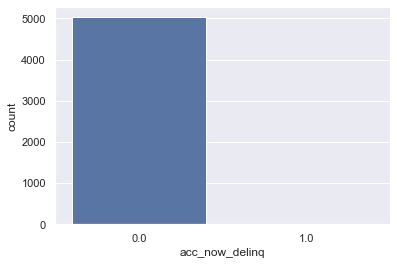

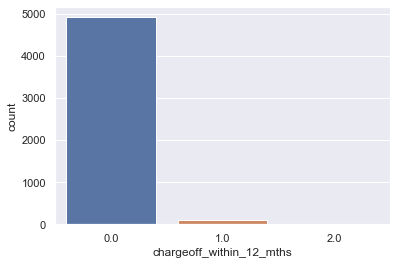

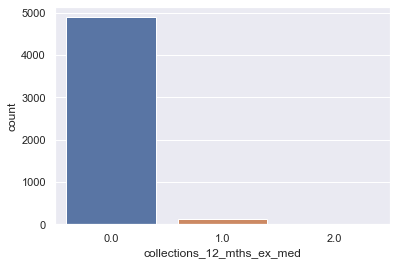

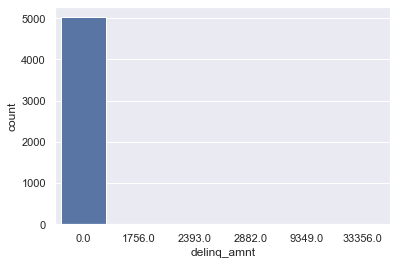

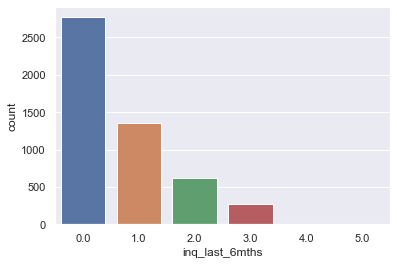

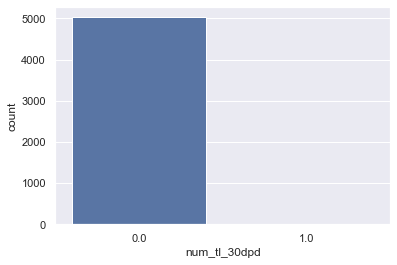

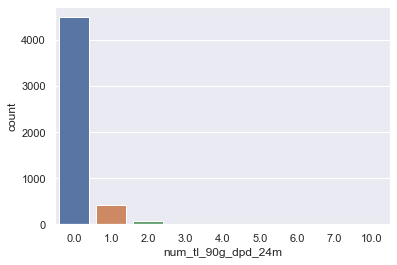

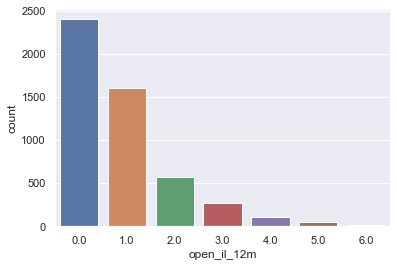

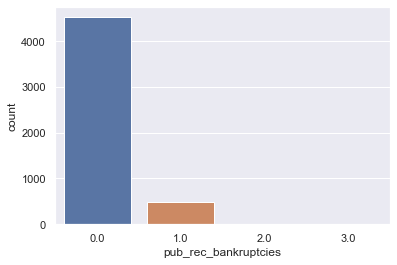

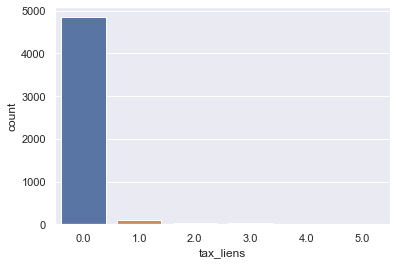

In [75]:
#Explore the frequency distribution of categorical variables
for var in categorical:
    plt.figure()
    ax = sns.countplot(x=var, data=df_bal)

#### We can see that the distribution of some categorical variables are heavily skewed. We might want to remove categories with low variance.

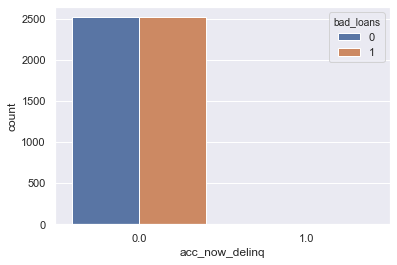

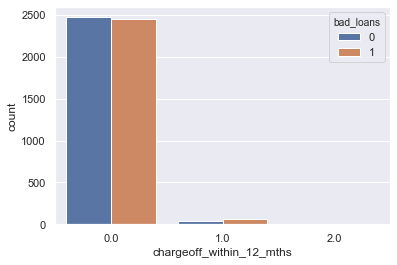

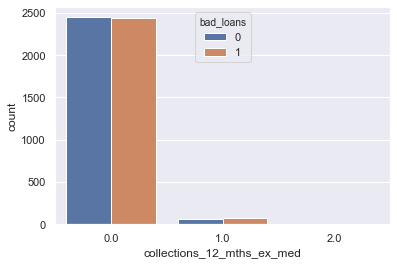

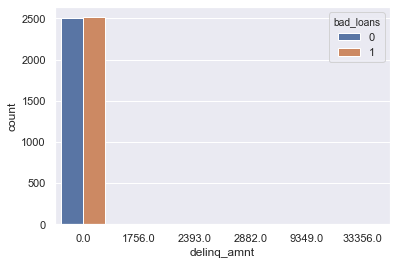

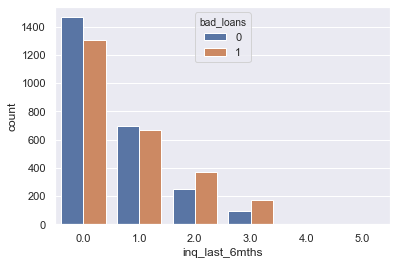

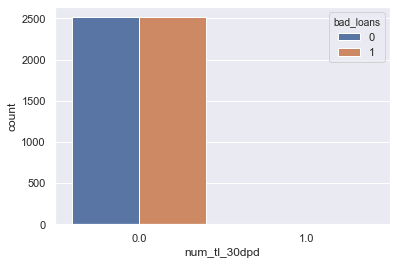

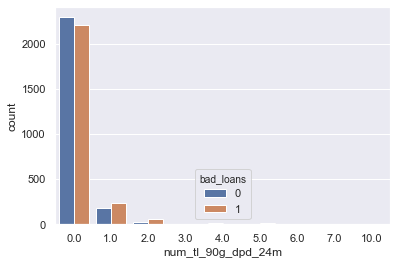

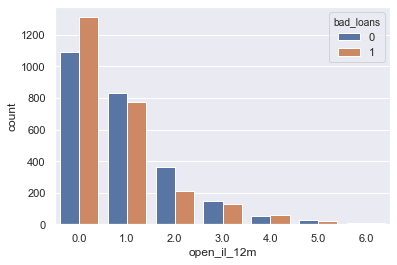

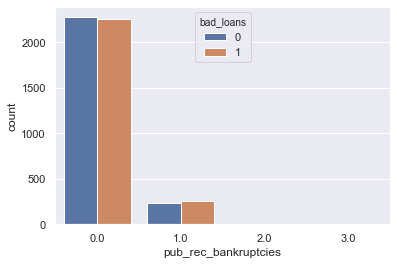

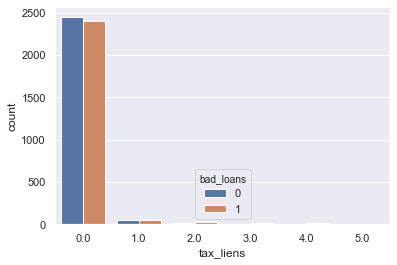

In [76]:
#Explore frequency of target distribution of categorical variables
for var in categorical:
    plt.figure()
    ax = sns.countplot(x=var, hue='bad_loans',data=df_bal)

### Explore the statistics of target distribution of numerical variables

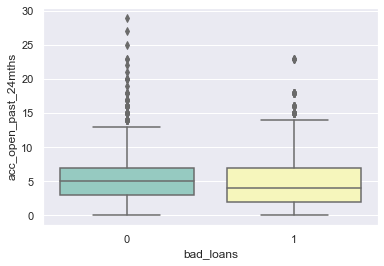

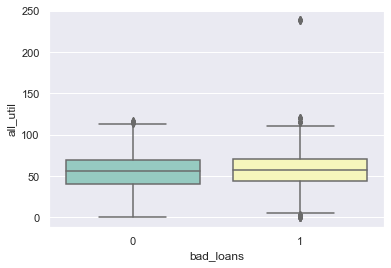

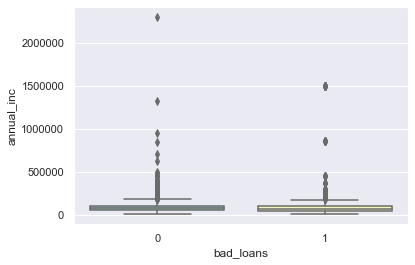

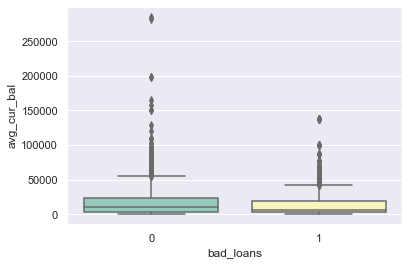

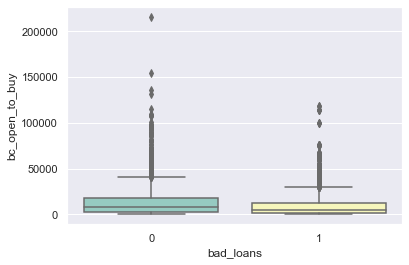

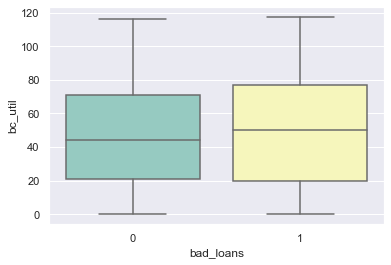

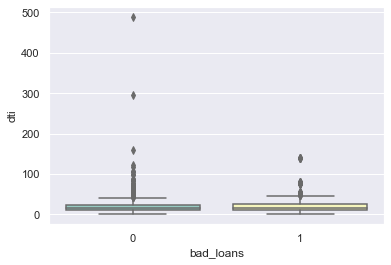

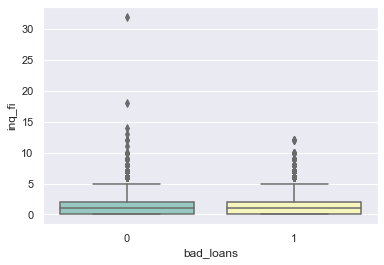

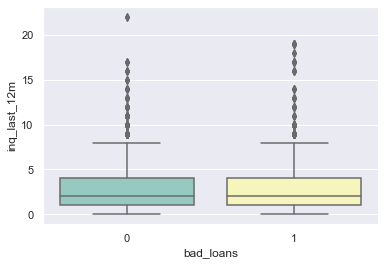

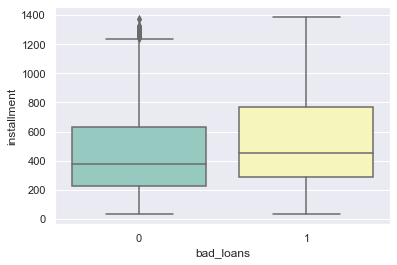

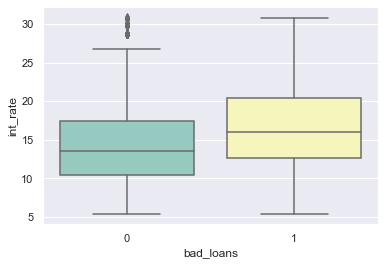

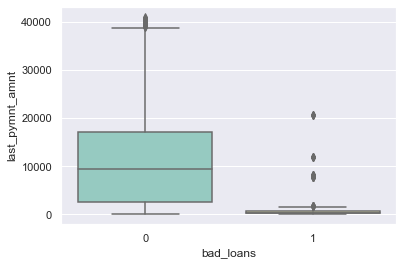

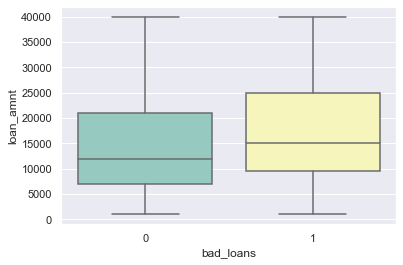

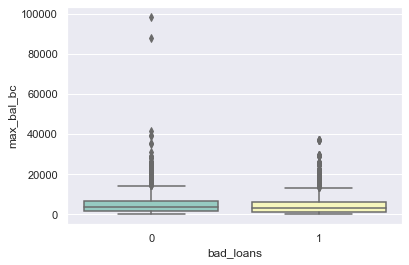

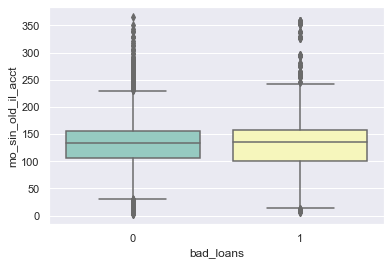

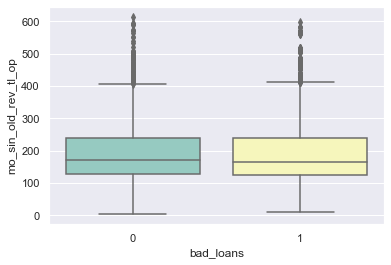

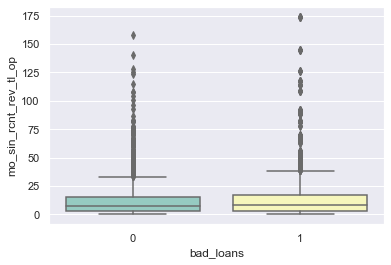

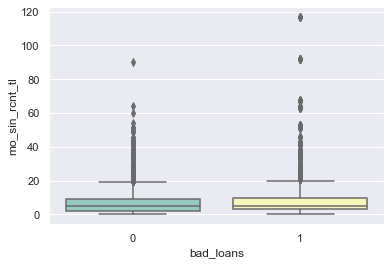

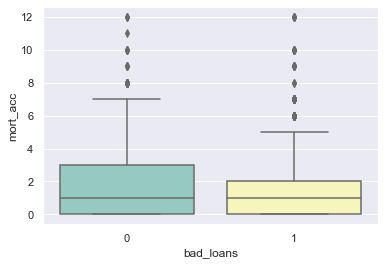

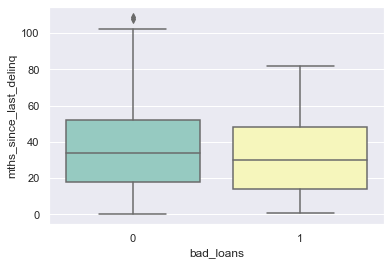

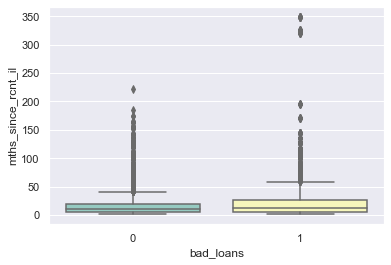

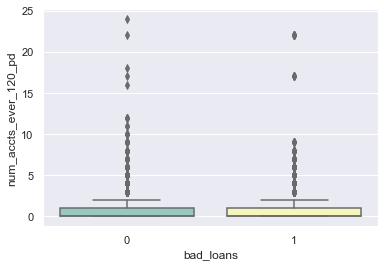

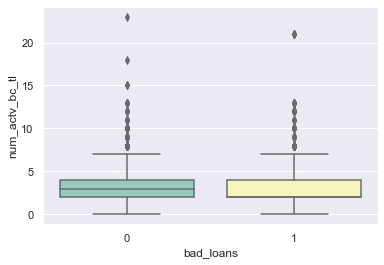

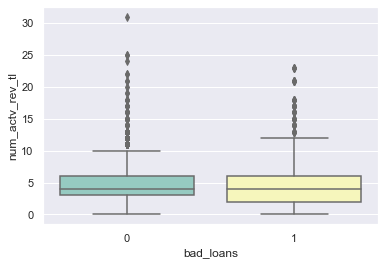

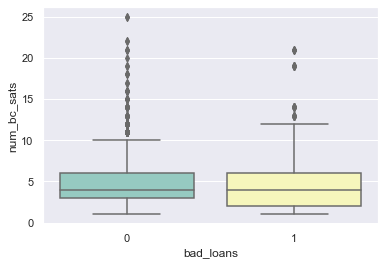

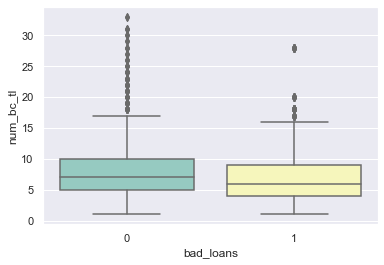

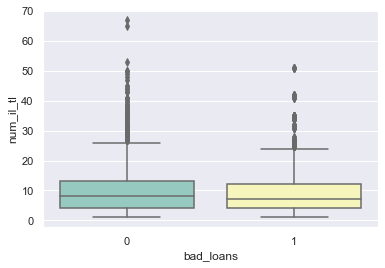

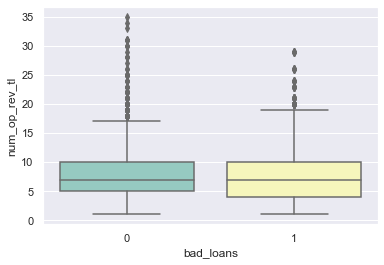

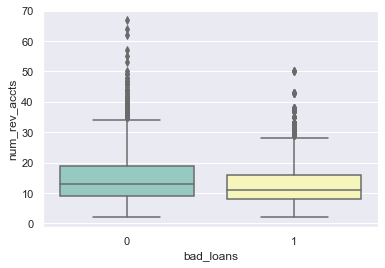

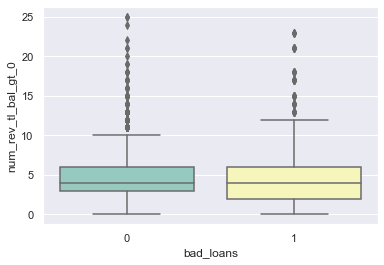

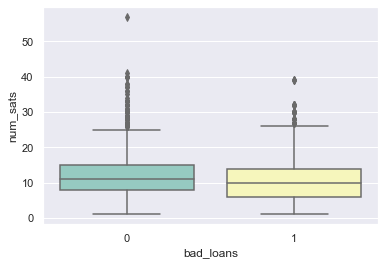

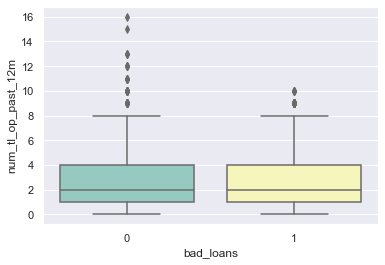

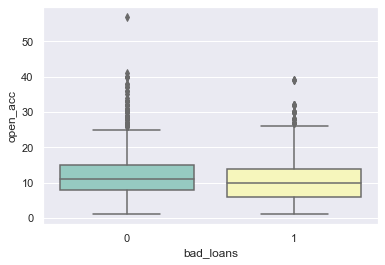

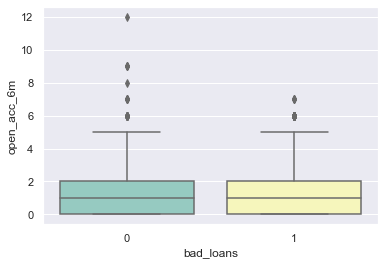

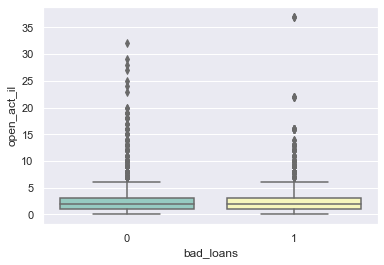

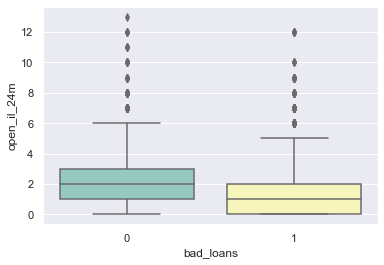

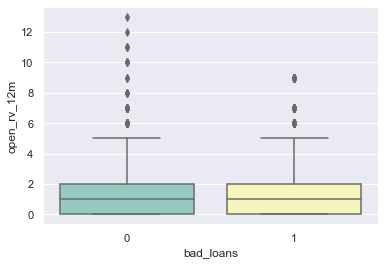

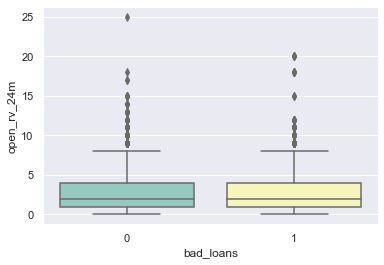

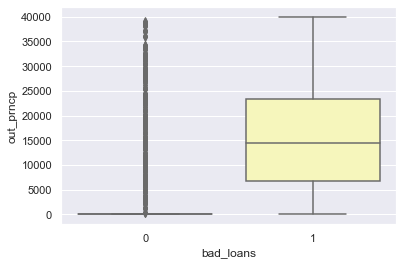

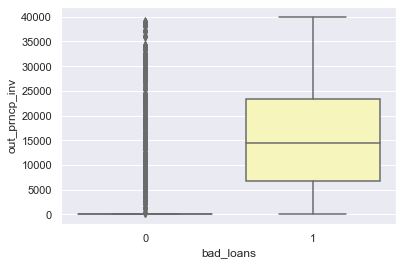

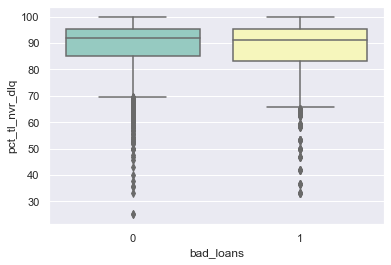

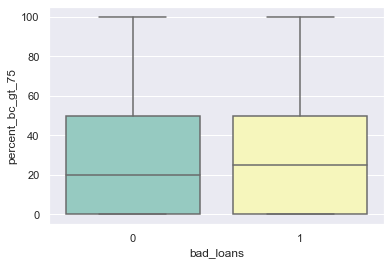

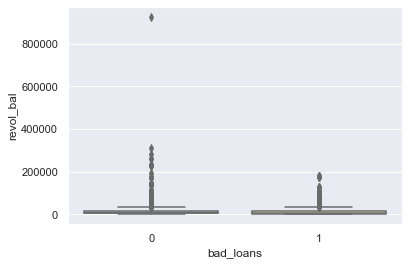

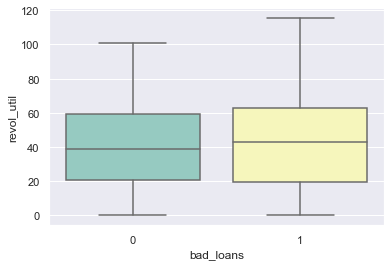

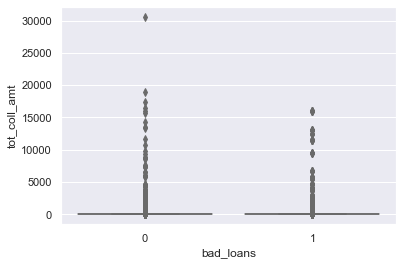

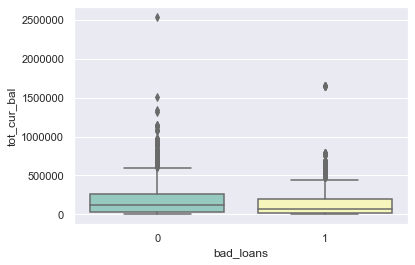

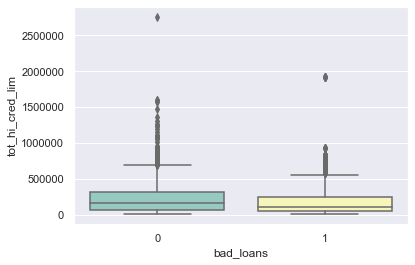

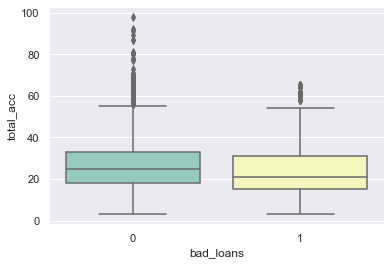

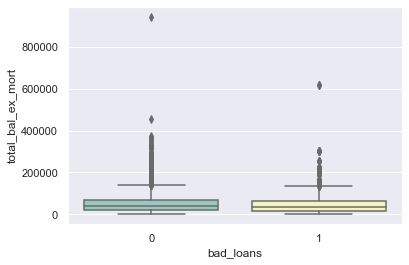

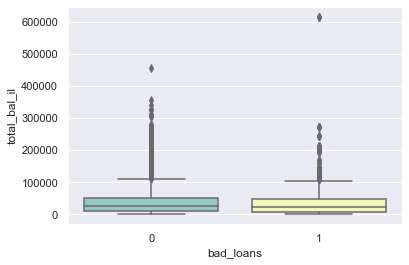

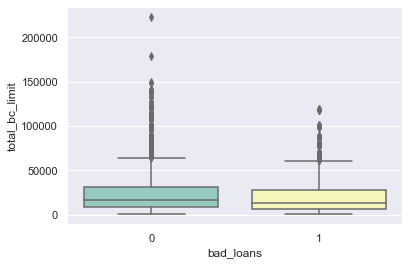

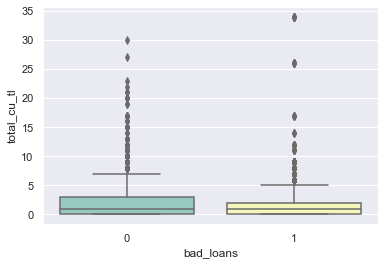

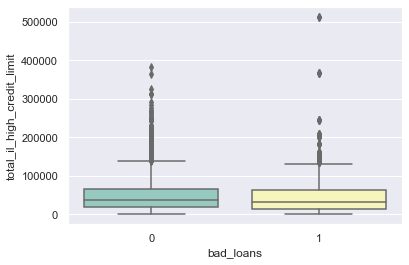

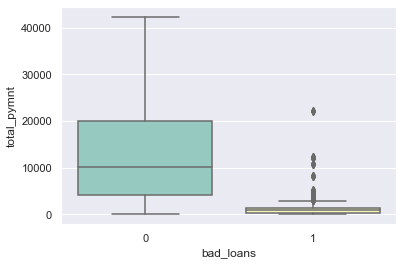

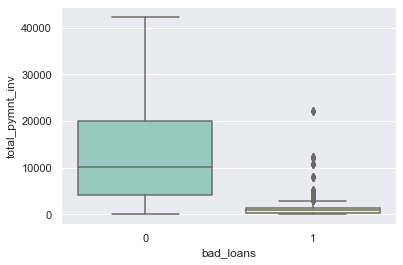

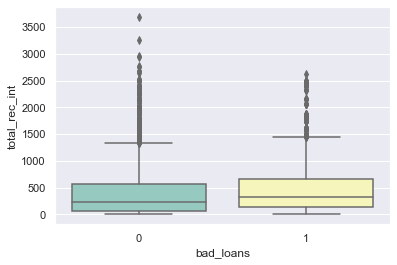

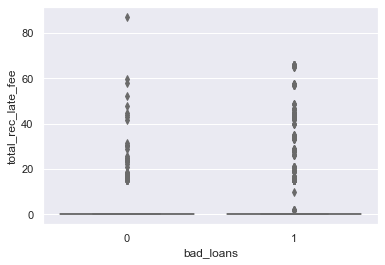

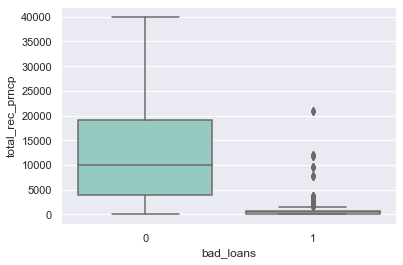

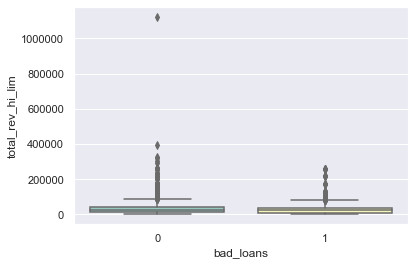

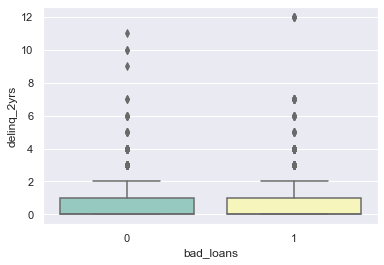

In [78]:
for var in numerical:
    plt.figure()
    ax = sns.boxplot(x="bad_loans", y=var,data=df_bal, palette="Set3")

### Explore the target distribution of bins of numerical variables

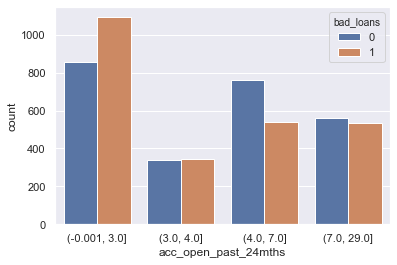

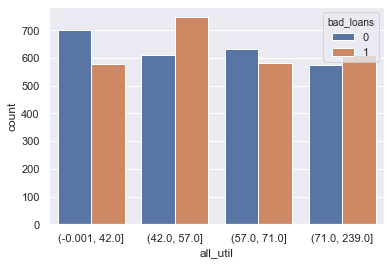

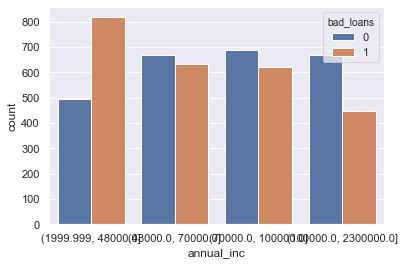

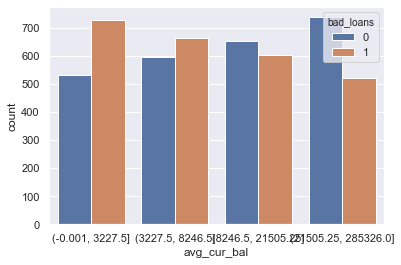

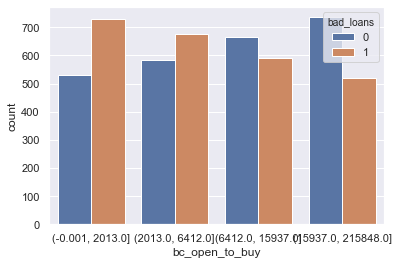

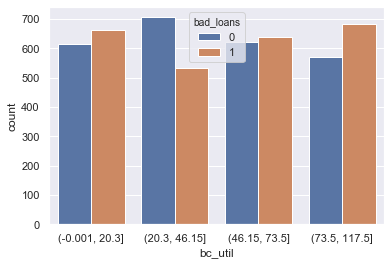

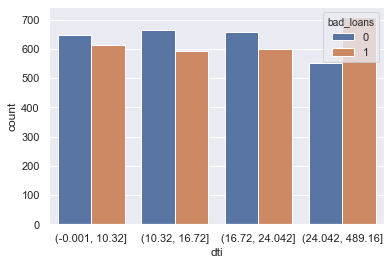

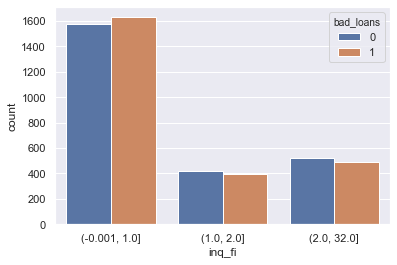

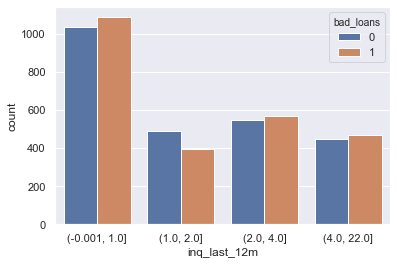

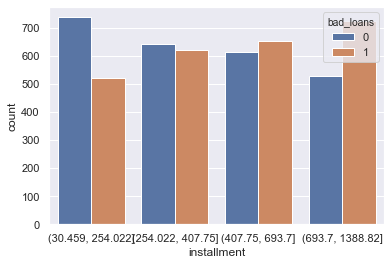

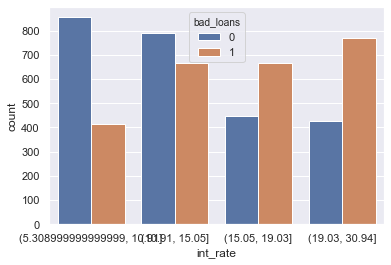

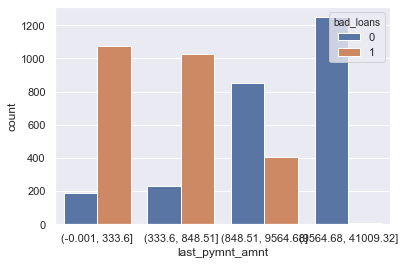

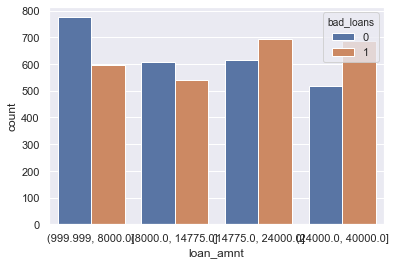

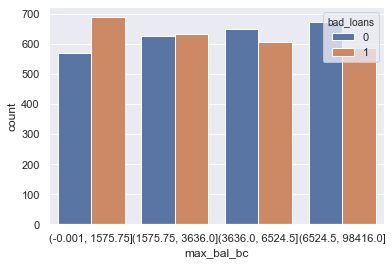

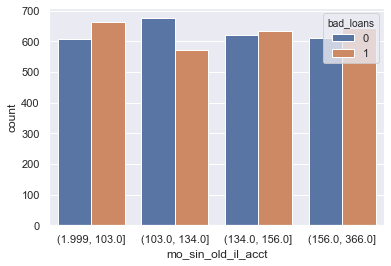

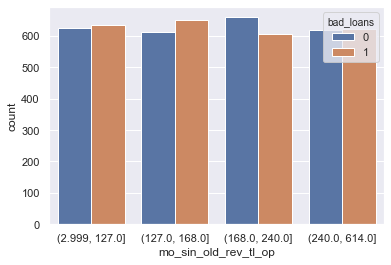

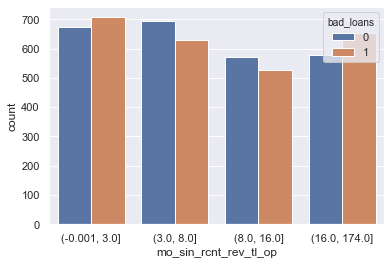

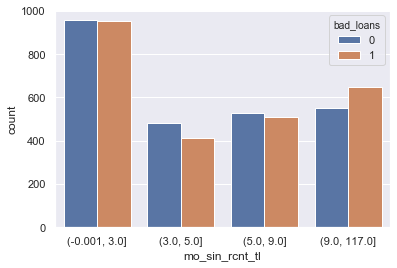

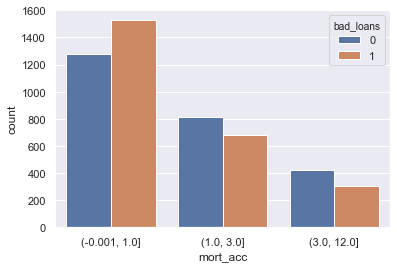

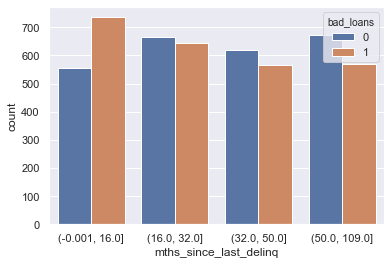

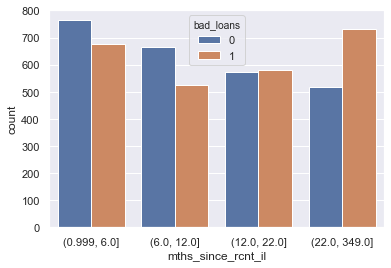

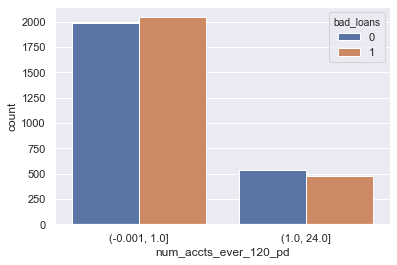

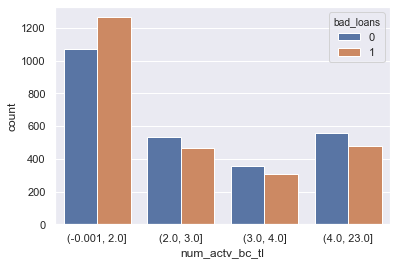

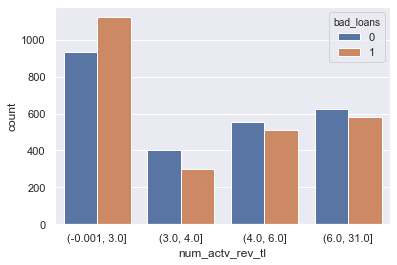

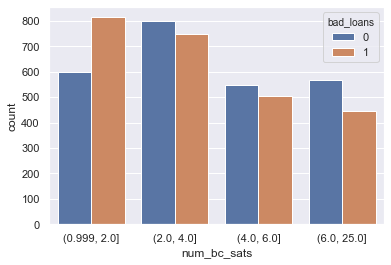

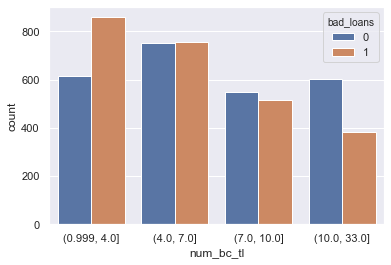

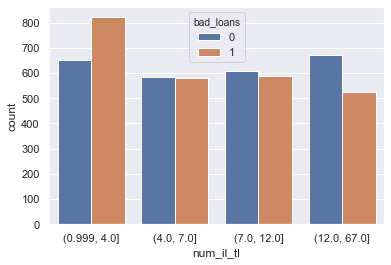

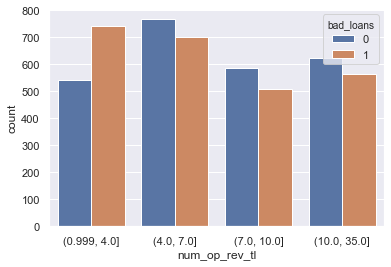

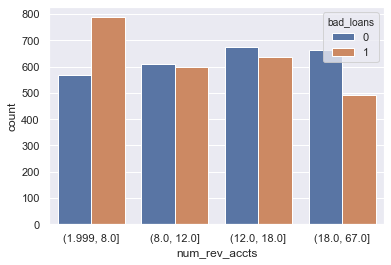

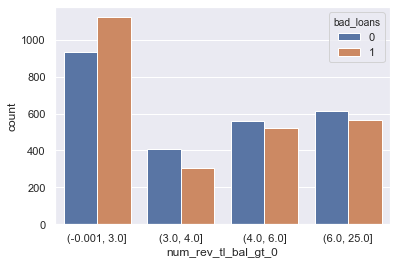

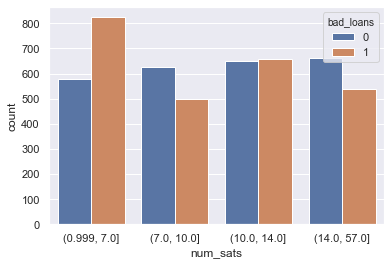

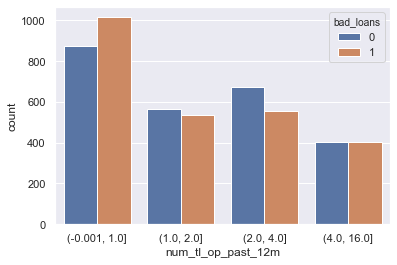

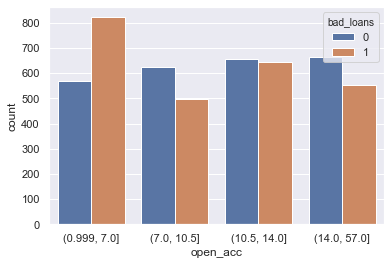

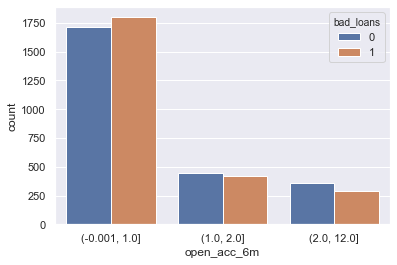

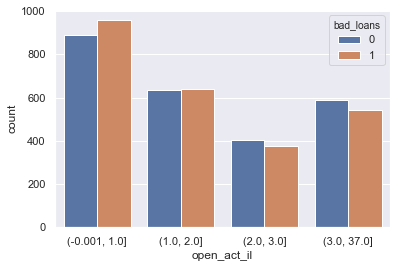

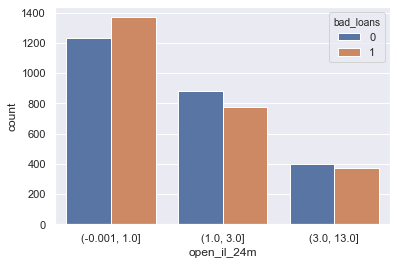

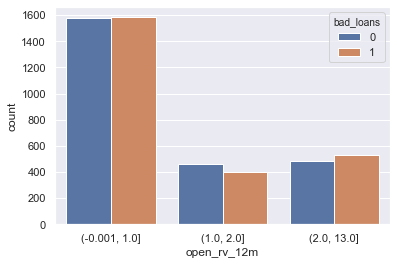

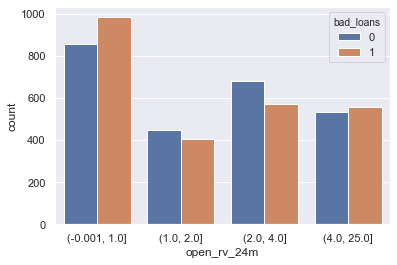

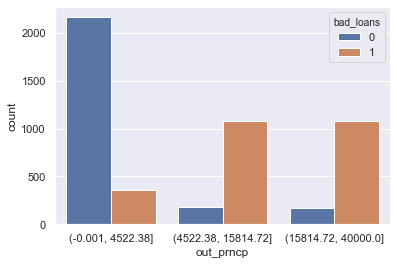

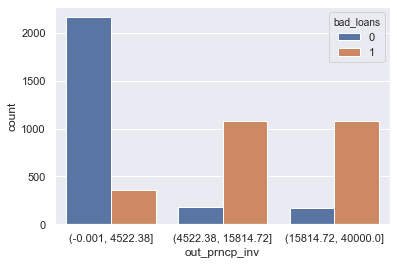

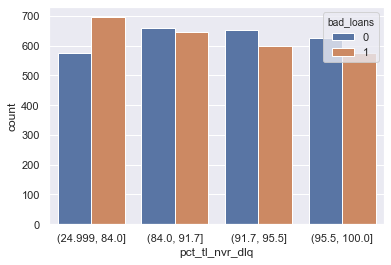

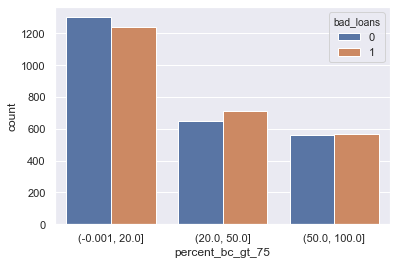

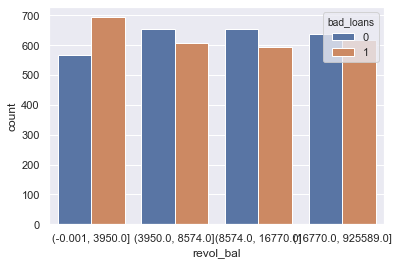

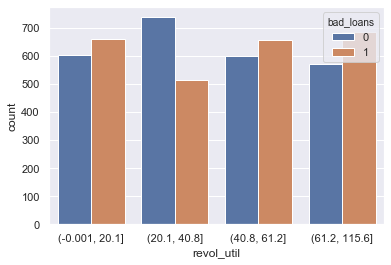

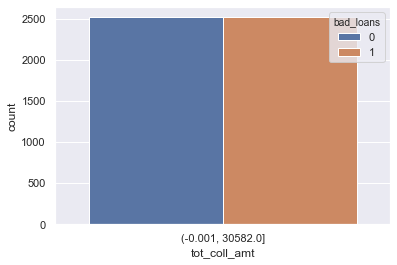

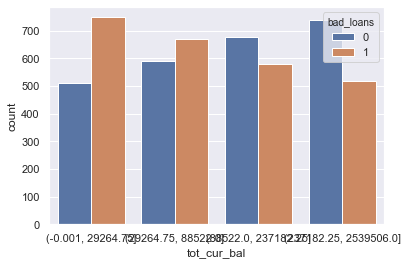

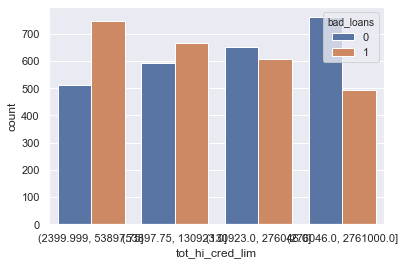

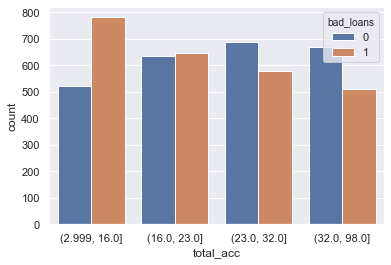

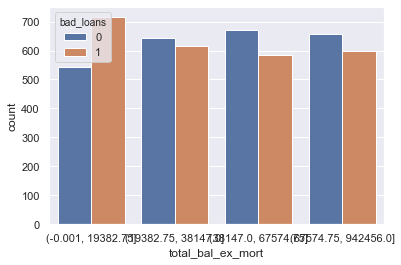

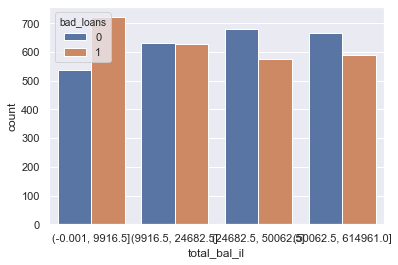

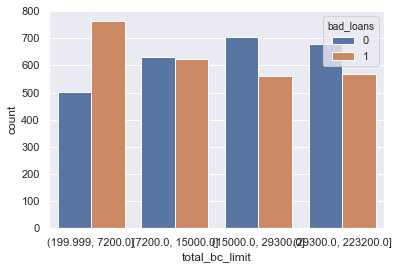

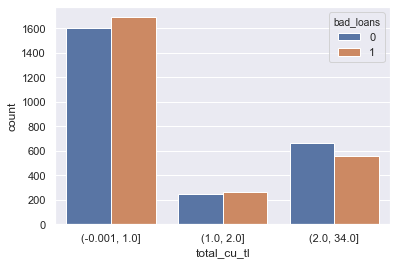

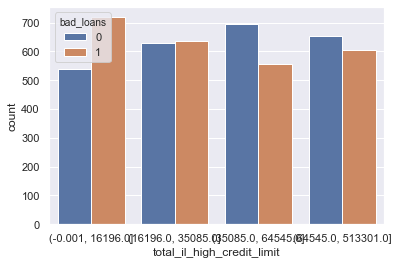

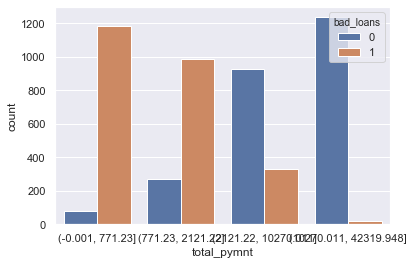

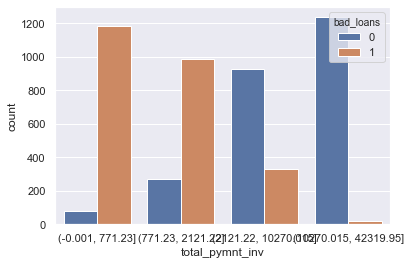

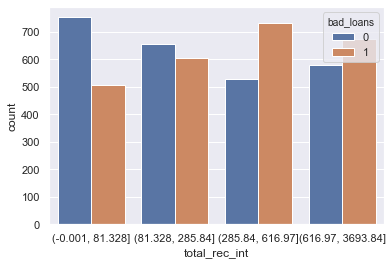

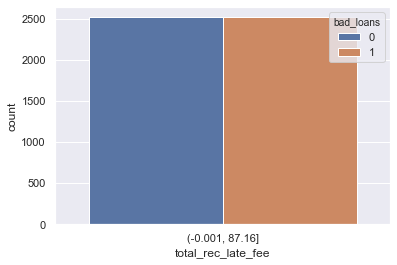

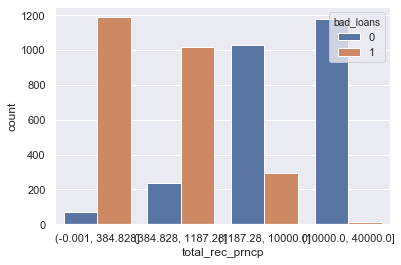

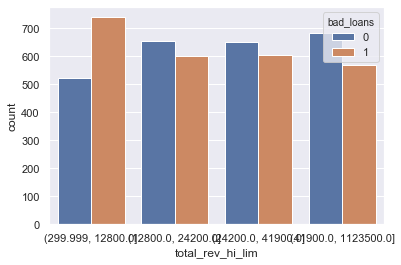

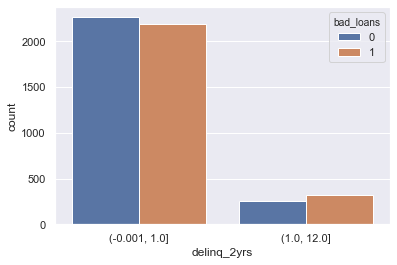

In [80]:
quantile_list = [0,0.25,0.5,0.75,1]
#quantile_labels = ['0-25Q','25-50Q','50-75Q','75-100Q']
df_bin = pd.DataFrame()
df_bin['bad_loans'] = df_bal['bad_loans']
for var in numerical:
    df_bin[var]=pd.qcut(df_bal[var],q=quantile_list,duplicates='drop')
    plt.figure()
    ax = sns.countplot(x=var, hue='bad_loans',data=df_bin)

## Feature Selection##

- With a large dataset of over 70 variables, feature selection is done to deduce relevant variables that would reduce overfitting
- With less redundant data, there would be lower probability of making decisions based on noise

**Techniques Used:**
- Correlation of attributes to target variable
- Information Gain
- Relative feature importance from Random Forest
- Relative feature importance from Gradient Boost Classifier

From the 4 test above, choose features that have been selected for 2 or more of these test

### 1) Select features based on categorical correlation of variables on target variables

In [81]:
import scipy.stats as stats
from scipy.stats import chi2_contingency

class ChiSquare:
    def __init__(self, dataframe):
        self.df = dataframe
        self.p = None #P-Value
        self.chi2 = None #Chi Test Statistic
        self.dof = None
        
        self.dfObserved = None
        self.dfExpected = None
        
    def _chisquare_result(self, colX, alpha):
        result = ""
        if self.p<alpha:
            result="{0} is IMPORTANT for Prediction".format(colX)
        else:
            result="{0} is NOT an important predictor. (Discard {0} from model)".format(colX)

        print(result)
        
    def TestIndependence(self,colX,colY, alpha=0.05):
        X = self.df[colX].astype(str)
        Y = self.df[colY].astype(str)
        
        self.dfObserved = pd.crosstab(Y,X) 
        chi2, p, dof, expected = stats.chi2_contingency(self.dfObserved.values)
        self.p = p
        self.chi2 = chi2
        self.dof = dof 
        
        self.dfExpected = pd.DataFrame(expected, columns=self.dfObserved.columns, index = self.dfObserved.index)
        if self.p<alpha:
            return True # accept variable
        else:
            return False

In [82]:
accept_cT = []
reject_cT = []

In [83]:
#Initialize ChiSquare Class
cT = ChiSquare(df_bal)

#Feature Selection
for var in categorical:
    status = cT.TestIndependence(colX=var,colY="bad_loans")  
    if status:
        accept_cT.append(var)
    else:
        reject_cT.append(var)

In [84]:
#Initialize ChiSquare Class
cT = ChiSquare(df_bin)

#Feature Selection
for var in numerical:
    status = cT.TestIndependence(colX=var,colY="bad_loans")  
    if status:
        accept_cT.append(var)
    else:
        reject_cT.append(var)

In [85]:
#Based on Chi Square test on categorical data, variables to remove:
reject_cT

['acc_now_delinq',
 'collections_12_mths_ex_med',
 'delinq_amnt',
 'num_tl_30dpd',
 'pub_rec_bankruptcies',
 'inq_fi',
 'mo_sin_old_rev_tl_op',
 'open_act_il',
 'percent_bc_gt_75',
 'tot_coll_amt',
 'total_rec_late_fee']

### 2) Select features based on information gain

In [86]:
accept_ig = []
reject_ig = []

In [87]:
from info_gain import info_gain

for var in numerical:
#ig = info_gain.info_gain(df_bal['bad_loans'], df_bal['int_rate'])
#iv  = info_gain.intrinsic_value(fruit, colour)
    igr = info_gain.info_gain_ratio(df_bal['bad_loans'], df_bal[var])
    # set benchmark as info_gain_ratio = 0.01
    if igr >= 0.01:
        accept_ig.append(var)
    else:
        reject_ig.append(var)

In [88]:
reject_ig

['acc_open_past_24mths',
 'all_util',
 'inq_fi',
 'inq_last_12m',
 'int_rate',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_last_delinq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_op_past_12m',
 'open_acc',
 'open_acc_6m',
 'open_act_il',
 'open_il_24m',
 'open_rv_12m',
 'open_rv_24m',
 'percent_bc_gt_75',
 'total_acc',
 'total_cu_tl',
 'delinq_2yrs']

### 3) Select features based on variable importance from Random Forest Classifier

In [89]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

features = numerical + categorical
rf_sel = SelectFromModel(RandomForestClassifier(n_estimators = 100), threshold='median')
rf_sel.fit(df_bal[features], df_bal['bad_loans'])

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,
                                                 random_state=None, verbose=0,
  

In [90]:
random_forest_feat = df_bal[features].columns[rf_sel.get_support()]
print(len(random_forest_feat))
print(random_forest_feat)

35
Index(['all_util', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'dti', 'installment', 'int_rate', 'last_pymnt_amnt', 'loan_amnt',
       'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'mths_since_last_delinq', 'mths_since_rcnt_il', 'num_bc_sats',
       'num_il_tl', 'num_rev_accts', 'out_prncp', 'out_prncp_inv',
       'pct_tl_nvr_dlq', 'revol_bal', 'revol_util', 'tot_cur_bal',
       'tot_hi_cred_lim', 'total_acc', 'total_bal_ex_mort', 'total_bal_il',
       'total_bc_limit', 'total_il_high_credit_limit', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_int', 'total_rec_prncp',
       'total_rev_hi_lim'],
      dtype='object')


### 4) Select features based on variable importance from Gradient Boosting Classifier

In [91]:
from sklearn.ensemble import GradientBoostingClassifier

gb_sel = SelectFromModel(GradientBoostingClassifier(n_estimators = 100), threshold='median')
gb_sel.fit(df_bal[features], df_bal['bad_loans'])
gradient_boost_feat = df_bal[features].columns[gb_sel.get_support()]
print(len(gradient_boost_feat))
print(gradient_boost_feat)

35
Index(['annual_inc', 'bc_util', 'dti', 'inq_fi', 'installment',
       'last_pymnt_amnt', 'loan_amnt', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_last_delinq', 'num_bc_tl', 'num_op_rev_tl',
       'num_rev_tl_bal_gt_0', 'num_sats', 'open_acc', 'open_rv_12m',
       'out_prncp', 'out_prncp_inv', 'pct_tl_nvr_dlq', 'revol_bal',
       'revol_util', 'tot_cur_bal', 'tot_hi_cred_lim', 'total_bal_il',
       'total_bc_limit', 'total_cu_tl', 'total_il_high_credit_limit',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee',
       'total_rec_prncp', 'total_rev_hi_lim'],
      dtype='object')


### Use of Majority Voting to Select Features

- using the four feature selection techniques above for majority voting
- ultimately choosing features that have been selected for two or more feature selection techniques employed above

In [92]:
correlation = []
infogain = []
randomforest_select = []
gradientboost_select = []
finalselection = pd.DataFrame()
for var in features:
    correlation.append(int(var in accept_cT))
    infogain.append(int(var in accept_ig))
    randomforest_select.append(int(var in random_forest_feat))
    gradientboost_select.append(int(var in gradient_boost_feat))

finalselection['variable'] = features
finalselection['correlation'] = correlation
finalselection['infogain'] = infogain
finalselection['randomforest_select'] = randomforest_select
finalselection['gradientboost_select'] = gradientboost_select
finalselection['sum'] = finalselection['correlation']+finalselection['infogain']+finalselection['randomforest_select']+finalselection['gradientboost_select']
finalselection['choice'] = finalselection['sum'] >= 2

In [93]:
finalselection.head(10)

,variable,correlation,infogain,randomforest_select,gradientboost_select,sum,choice
0,acc_open_past_24mths,1,0,0,0,1,False
1,all_util,1,0,1,0,2,True
2,annual_inc,1,1,1,1,4,True
3,avg_cur_bal,1,1,1,0,3,True
4,bc_open_to_buy,1,1,1,0,3,True
5,bc_util,1,1,1,1,4,True
6,dti,1,1,1,1,4,True
7,inq_fi,0,0,0,1,1,False
8,inq_last_12m,1,0,0,0,1,False
9,installment,1,1,1,1,4,True


In [94]:
reduced_features =finalselection['variable'][finalselection['choice'] == True].values
print(len(reduced_features))
reduced_features

45


array(['all_util', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy',
       'bc_util', 'dti', 'installment', 'int_rate', 'last_pymnt_amnt',
       'loan_amnt', 'max_bal_bc', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_last_delinq', 'mths_since_rcnt_il', 'num_bc_sats',
       'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts',
       'num_rev_tl_bal_gt_0', 'num_sats', 'open_acc', 'open_rv_12m',
       'out_prncp', 'out_prncp_inv', 'pct_tl_nvr_dlq', 'revol_bal',
       'revol_util', 'tot_cur_bal', 'tot_hi_cred_lim', 'total_acc',
       'total_bal_ex_mort', 'total_bal_il', 'total_bc_limit',
       'total_cu_tl', 'total_il_high_credit_limit', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee',
       'total_rec_prncp', 'total_rev_hi_lim'], dtype=object)

### Check for correlation between features selected

- Removing features that are highly correlated (e.g. corr >= 0.9)
- This removes away unnecessary features that statistically are unable to separate target classes

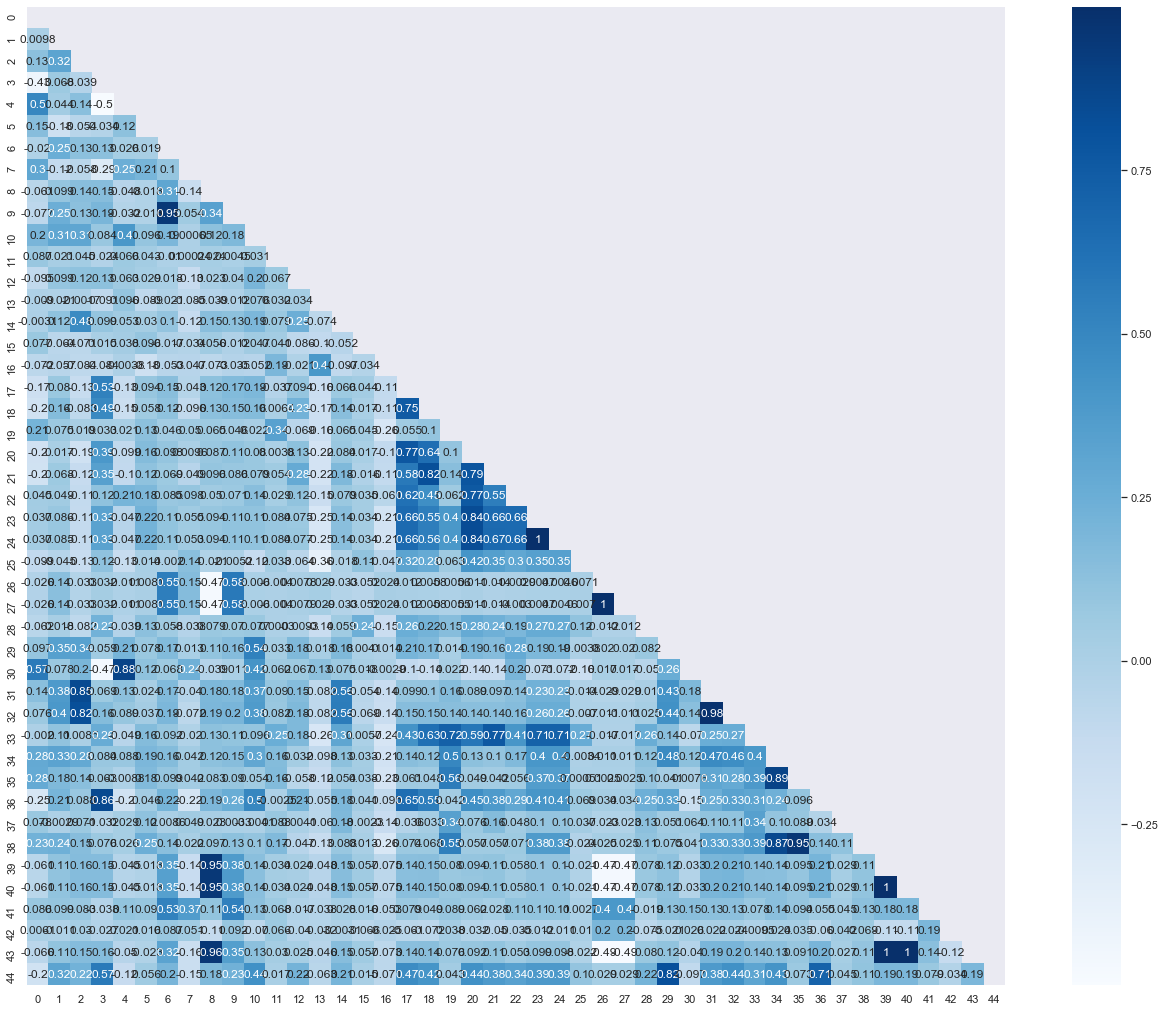

In [95]:
arr_corr = df_bal[reduced_features].corr().as_matrix()
arr_corr[np.triu_indices_from(arr_corr)] = np.nan
fig, ax = plt.subplots(figsize=(24, 18))
hm = sns.heatmap(arr_corr,annot=True, square=True, cmap=plt.cm.Blues)

In [96]:
# Removing one of the variables if correlation is >= 0.9
corr = df_bal[reduced_features].corr()
col = np.full((corr.shape[0]), True, dtype = bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i, j] >= 0.9:
            if col[j]:
                col[j] = False
                
reduced_features2 = df_bal[reduced_features].columns[col]
print(len(reduced_features2))
reduced_features2

37


Index(['all_util', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'dti', 'installment', 'int_rate', 'last_pymnt_amnt', 'max_bal_bc',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_last_delinq', 'mths_since_rcnt_il',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'open_rv_12m',
       'out_prncp', 'pct_tl_nvr_dlq', 'revol_bal', 'revol_util', 'tot_cur_bal',
       'total_acc', 'total_bal_ex_mort', 'total_bal_il', 'total_bc_limit',
       'total_cu_tl', 'total_rec_int', 'total_rec_late_fee',
       'total_rev_hi_lim'],
      dtype='object')

## Dimensionality Reduction

- Using PCA to reduce the number of random variables under consideration to obtain principal variables

In [118]:
from sklearn.decomposition import PCA

In [119]:
scaler = MinMaxScaler(feature_range=[0, 1])
reduced_features2_rescaled = scaler.fit_transform(df_bal[reduced_features2])

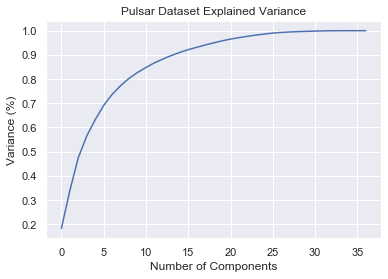

In [120]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(reduced_features2_rescaled)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

#### This plot tells us that selecting 25 components we can preserve something around 0.98 or 0.99 of total variance of the data. We do not want to use 100% of our variance, because it denotes all components, and  we want only the principal ones

In [121]:
pca = PCA(n_components=25)
reduced_dim_features = pca.fit_transform(reduced_features2_rescaled)
reduced_dim_features

array([[-9.27721625e-02,  1.49892362e-01,  3.72572778e-01, ...,
        -2.26792177e-02,  7.02206674e-02,  2.76522065e-02],
       [ 2.17513206e-01,  4.14846127e-01, -5.54037003e-02, ...,
        -1.79894678e-02, -4.26832810e-02, -1.71318689e-02],
       [-1.33110776e-01,  3.45348733e-01,  1.28327521e-01, ...,
         3.43179775e-02,  9.08092022e-02, -1.23311581e-02],
       ...,
       [ 3.30882547e-01, -1.79484618e-01, -1.54618708e-03, ...,
        -3.23382314e-02,  6.88716475e-02, -5.34832839e-02],
       [-3.46533027e-01, -3.95292217e-01,  4.20934417e-01, ...,
        -4.21002559e-02, -2.82720198e-02,  3.44656990e-02],
       [ 6.02962510e-01, -1.22975132e-02, -3.09910922e-02, ...,
        -1.69328294e-02, -4.86540820e-02, -1.59713320e-04]])

## Modelling and Optimisation
**Models used:** 
- Logistic Regression
- Naive Bayes
- Decision Tree
- Random Forest
- XG Boost
- SVM
- Neural Networks


**Optimisation**

In order to tune the parameters of the model, performed Bayesian Optimisation with the use of F1 score that takes into account Precision and Recall value. This would convey the balance between them (False Positive and False Negative)

In [313]:
X_train, X_test, y_train, y_test = train_test_split(reduced_dim_features, df_bal['bad_loans'], test_size=0.2, random_state = 1234) #Keep training

In [314]:
X = reduced_dim_features
y = df_bal['bad_loans']

In [315]:
## Scoring functions ##
from colorama import Fore
from sklearn.metrics import confusion_matrix
def scoring(X,y,y_test,y_pred, y_pred_prob, model):
    tn,fp,fn,tp=confusion_matrix(y_test,y_pred).ravel()
    print('True positive is ', tp)
    print('True negative is ', tn)
    print('False positive is ', fp)
    print('False negative is ', fn)
    
    accuracy = cross_val_score(model, X, y, cv = 5, scoring='accuracy').mean()
    f1 = cross_val_score(model, X, y, cv = 5, scoring='f1').mean()
    precision = cross_val_score(model, X, y, cv = 5, scoring='precision').mean()
    recall = cross_val_score(model, X, y, cv = 5, scoring='recall').mean()
    roc_auc = cross_val_score(model, X, y, cv = 5, scoring='roc_auc').mean()
    
    print('Cross validation mean accuracy is ', accuracy)
    print('Cross validation mean f1 is ', f1)
    print('Cross validation mean precision is ', precision)
    print('Cross validation mean recall is ', recall)
    print('Cross validation mean roc_auc is ', roc_auc)
    
    y_prob = y_pred_prob[:,1]
    data = {'y':list(y_pred), 'p':list(y_prob)}
    out = pd.DataFrame(data)
    ks_score_test = ks(data=out, target ='y', prob ='p')
    
def ks(data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 10, duplicates='drop')
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100

    #Formating
    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    #kstable.index = range(1,11)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 9)
    print(kstable)
    
    #Display KS
    print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return(kstable)

### Modelling with Logistic Regression

In [102]:
def lr_cv(C, data, targets):
    
    clf = LogisticRegression(C=C,
                             random_state=1234)
    cval = cross_val_score(clf, data, targets,scoring='f1', cv=5)
    return cval.mean()

def optimize_lr(data, targets):
    """Apply Bayesian Optimization to Random Forest parameters."""
    def lr_crossval(C):
        return lr_cv(
            C = 10**int(C),
            data=data,
            targets=targets)
    optimizer = BayesianOptimization(
        f=lr_crossval,
        pbounds={
            'C': (-3,3)},
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=10)

    print("Final result:", optimizer.max)

In [321]:
optimize_lr(X_train, y_train)

|   iter    |  target   |     C     |
-------------------------------------
|  1        |  0.8765   | -1.851    |
|  2        |  0.8907   |  0.7327   |
|  3        |  0.8907   | -0.3736   |
|  4        |  0.8953   |  1.712    |
|  5        |  0.8953   |  1.68     |
|  6        |  0.8987   |  3.0      |
|  7        |  0.8987   |  3.0      |
|  8        |  0.898    |  3.0      |
|  9        |  0.898    |  3.0      |
|  10       |  0.898    |  3.0      |
|  11       |  0.898    |  2.619    |
|  12       |  0.898    |  3.0      |
|  13       |  0.898    |  3.0      |
|  14       |  0.898    |  3.0      |
|  15       |  0.898    |  2.613    |
Final result: {'target': 0.8987448452082634, 'params': {'C': 3.0}}


In [322]:
clf_log = LogisticRegression(C= 10**3, fit_intercept = True, random_state=1234)
clf_log.fit(X_train, y_train)
y_pred_log = clf_log.predict(X_test)
y_pred_prob_log = clf_log.predict_proba(X_test)

scoring(X,y,y_test,y_pred_log,y_pred_prob_log,clf_log)

True positive is  492
True negative is  417
False positive is  85
False negative is  13
Cross validation mean accuracy is  0.8867394837325255
Cross validation mean f1 is  0.8953103239229684
Cross validation mean precision is  0.8392064898612338
Cross validation mean recall is  0.9610558869008173
Cross validation mean roc_auc is  0.9411101538913416
            min_prob      max_prob  events  nonevents event_rate  \
Decile                                                             
1       9.555099e-01  9.979900e-01      99          0     17.16%   
2       9.022385e-01  9.550253e-01     103          0     17.85%   
3       8.375525e-01  9.003037e-01      99          0     17.16%   
4       7.809286e-01  8.373888e-01     102          0     17.68%   
5       6.736339e-01  7.802474e-01     100          0     17.33%   
6       3.058862e-01  6.733453e-01      74         27     12.82%   
7       1.263237e-02  3.030386e-01       0        101      0.00%   
8       1.690506e-04  1.089029e-02    

### Modelling with Naive Bayes

In [103]:
from sklearn.naive_bayes import GaussianNB

In [325]:
clf_nb = GaussianNB().fit(X_train, y_train)
y_pred_nb = clf_nb.predict(X_test)
y_pred_prob_nb = clf_nb.predict_proba(X_test)

scoring(X,y,y_test,y_pred_nb,y_pred_prob_nb,clf_nb)

True positive is  349
True negative is  431
False positive is  71
False negative is  156
Cross validation mean accuracy is  0.7831873836346996
Cross validation mean f1 is  0.7708185501082306
Cross validation mean precision is  0.8192549586805027
Cross validation mean recall is  0.7285304048723532
Cross validation mean roc_auc is  0.8615115618889753
        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1       0.993632  1.000000     101          0     24.05%         0.00%   
2       0.930025  0.993545     101          0     24.05%         0.00%   
3       0.766229  0.929839      98          0     23.33%         0.00%   
4       0.541698  0.764341     103          0     24.52%         0.00%   
5       0.339983  0.540197      17         83      4.05%        14.14%   
6       0.216069  0.339530       0        101      0.00%        17.21%   
7       0.110703  0.216009       0        101      0.00% 

### Modelling with Decision Tree

In [104]:
def dt_cv(max_depth, min_samples_split, min_samples_leaf, max_leaf_nodes, data, targets):
    
    clf = DecisionTreeClassifier(max_depth=max_depth,
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf, 
                                 max_leaf_nodes=max_leaf_nodes,
                                 random_state=1234)
    cval = cross_val_score(clf, data, targets,scoring='precision', cv=5)
    return cval.mean()

def optimize_dt(data, targets):
    """Apply Bayesian Optimization to Random Forest parameters."""
    def dt_crossval(max_depth, min_samples_split, min_samples_leaf, max_leaf_nodes):
        return dt_cv(
            max_depth=int(max_depth),
            min_samples_split = int(min_samples_split),
            min_samples_leaf = int(min_samples_leaf),
            max_leaf_nodes = int(max_leaf_nodes),
            data=data,
            targets=targets)
    optimizer = BayesianOptimization(
        f=dt_crossval,
        pbounds={
            'max_depth': (2, 12),
            'min_samples_split': (10, 30),
            'min_samples_leaf': (2, 12),
            'max_leaf_nodes':(5, 10)},
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=10)

    print("Final result:", optimizer.max)

In [342]:
optimize_dt(X_train, y_train)

|   iter    |  target   | max_depth | max_le... | min_sa... | min_sa... |
-------------------------------------------------------------------------
|  1        |  0.7507   |  3.915    |  8.111    |  6.377    |  25.71    |
|  2        |  0.8075   |  9.8      |  6.363    |  4.765    |  26.04    |
|  3        |  0.7946   |  11.58    |  9.38     |  5.578    |  20.02    |
|  4        |  0.8039   |  8.835    |  8.564    |  5.703    |  21.22    |
|  5        |  0.7582   |  7.031    |  5.069    |  9.728    |  27.65    |
|  6        |  0.8178   |  2.0      |  5.0      |  2.0      |  10.0     |
|  7        |  0.7582   |  12.0     |  5.0      |  12.0     |  10.0     |
|  8        |  0.7582   |  12.0     |  5.0      |  2.0      |  15.0     |
|  9        |  0.8178   |  2.0      |  10.0     |  12.0     |  10.0     |
|  10       |  0.8178   |  2.0      |  5.0      |  12.0     |  10.0     |
|  11       |  0.7923   |  12.0     |  10.0     |  2.0      |  30.0     |
|  12       |  0.8178   |  2.584    | 

In [352]:
clf_tree = DecisionTreeClassifier(random_state=1234, max_depth = 2, min_samples_split = 10, min_samples_leaf = 2, max_leaf_nodes = 5)
clf_tree.fit(X_train, y_train)
y_pred_tree = clf_tree.predict(X_test)
y_pred_prob_tree = clf_tree.predict_proba(X_test)

scoring(X,y,y_test,y_pred_tree,y_pred_prob_tree,clf_tree)

True positive is  369
True negative is  435
False positive is  67
False negative is  136
Cross validation mean accuracy is  0.7712656600082047
Cross validation mean f1 is  0.7536079921910296
Cross validation mean precision is  0.8160595537703144
Cross validation mean recall is  0.7015076209410205
Cross validation mean roc_auc is  0.8250413447483179
        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
0       0.819644  0.819644     436          0    100.00%         0.00%   
1       0.081897  0.398959       0        571      0.00%       100.00%   

       cum_eventrate cum_noneventrate     KS  
Decile                                        
0            100.00%            0.00%  100.0  
1            100.00%          100.00%    0.0  
KS is 100.0% at decile 0


### Modelling with RandomForest

In [105]:
def rf_cv(max_depth, n_estimators, min_samples_split, min_samples_leaf, max_leaf_nodes, data, targets):
    
    clf = RandomForestClassifier(max_depth=max_depth,
                                 n_estimators=n_estimators,
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf, 
                                 max_leaf_nodes=max_leaf_nodes,
                                 random_state=1234)
    cval = cross_val_score(clf, data, targets,scoring='f1', cv=5)
    return cval.mean()

def optimize_rf(data, targets):
    """Apply Bayesian Optimization to Random Forest parameters."""
    def rf_crossval(max_depth, n_estimators, min_samples_split, min_samples_leaf, max_leaf_nodes):
        return rf_cv(
            max_depth=int(max_depth),
            n_estimators=2**int(n_estimators),
            min_samples_split = int(min_samples_split),
            min_samples_leaf = int(min_samples_leaf),
            max_leaf_nodes = int(max_leaf_nodes),
            data=data,
            targets=targets)
    optimizer = BayesianOptimization(
        f=rf_crossval,
        pbounds={
            'max_depth': (2, 12),
            'n_estimators':(1,8),
            'min_samples_split': (10, 30),
            'min_samples_leaf': (2, 12),
            'max_leaf_nodes':(5, 10)},
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=10)

    print("Final result:", optimizer.max)

In [331]:
optimize_rf(X_train, y_train)

|   iter    |  target   | max_depth | max_le... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
|  1        |  0.8332   |  3.915    |  8.111    |  6.377    |  25.71    |  6.46     |
|  2        |  0.8329   |  4.726    |  6.382    |  10.02    |  29.16    |  7.132    |
|  3        |  0.8005   |  5.578    |  7.505    |  8.835    |  24.25    |  3.592    |
|  4        |  0.8411   |  7.612    |  7.515    |  2.138    |  25.46    |  7.178    |
|  5        |  0.8455   |  5.649    |  8.077    |  2.754    |  17.38    |  7.532    |
|  6        |  0.8094   |  2.0      |  5.002    |  2.0      |  23.98    |  8.0      |
|  7        |  0.8595   |  12.0     |  10.0     |  12.0     |  10.0     |  8.0      |
|  8        |  0.86     |  12.0     |  10.0     |  10.53    |  30.0     |  8.0      |
|  9        |  0.8609   |  12.0     |  10.0     |  2.0      |  10.0     |  8.0      |
|  10       |  0.8037   |  2.0      |  10.0     |  10.

In [347]:
clf_rf = RandomForestClassifier(random_state=1234, max_depth=12, n_estimators=256, min_samples_split=10, min_samples_leaf=2, max_leaf_nodes=10)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
y_pred_prob_rf = clf_rf.predict_proba(X_test)

scoring(X,y,y_test,y_pred_rf,y_pred_prob_rf,clf_rf)

True positive is  449
True negative is  437
False positive is  65
False negative is  56
Cross validation mean accuracy is  0.864875429959923
Cross validation mean f1 is  0.8677937000602235
Cross validation mean precision is  0.8541409943551986
Cross validation mean recall is  0.8831463599356244
Cross validation mean roc_auc is  0.9243233546196705
        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1       0.758738  0.817597     100          0     19.46%         0.00%   
2       0.731024  0.756982     102          0     19.84%         0.00%   
3       0.692178  0.730296      98          0     19.07%         0.00%   
4       0.623382  0.690035     103          0     20.04%         0.00%   
5       0.512885  0.623252     100          0     19.46%         0.00%   
6       0.412126  0.511733      11         90      2.14%        18.26%   
7       0.323061  0.410013       0        101      0.00%   

### Modelling with XGBoost

In [106]:
def xgb_cv(eta, max_depth, subsample, colsample_bytree, data, targets):
    
    clf = XGBClassifier(eta=eta,
                        max_depth=max_depth,
                        subsample=subsample,
                        colsample_bytree=colsample_bytree,
                        random_state=1234)
    cval = cross_val_score(clf, data, targets,scoring='f1', cv=5)
    return cval.mean()

def optimize_xgb(data, targets):
    """Apply Bayesian Optimization to XGBoost parameters."""
    def xgb_crossval(eta, max_depth, subsample, colsample_bytree):
        return xgb_cv(
            eta = max(0.05*int(eta), 0.01),
            max_depth=int(max_depth),
            subsample = int(subsample),
            colsample_bytree = int(colsample_bytree),
            data=data,
            targets=targets)
    optimizer = BayesianOptimization(
        f=xgb_crossval,
        pbounds={
            'eta': (0, 5),
            'max_depth': (2, 12),
            'subsample': (0.3, 1),
            'colsample_bytree':(0.3, 1)},
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=10)

    print("Final result:", optimizer.max)

In [327]:
optimize_xgb(X_train, y_train)

|   iter    |  target   | colsam... |    eta    | max_depth | subsample |
-------------------------------------------------------------------------
|  1        |  0.0      |  0.4341   |  3.111    |  6.377    |  0.8498   |
|  2        |  0.0      |  0.846    |  1.363    |  4.765    |  0.8613   |
|  3        |  0.0      |  0.9707   |  4.38     |  5.578    |  0.6507   |
|  4        |  0.0      |  0.7784   |  3.564    |  5.703    |  0.6928   |
|  5        |  0.0      |  0.6522   |  0.06884  |  9.728    |  0.9178   |
|  6        |  0.0      |  0.5064   |  0.1591   |  12.0     |  0.8007   |
|  7        |  0.0      |  0.4244   |  4.835    |  2.001    |  0.6365   |
|  8        |  0.0      |  0.8101   |  0.02235  |  11.96    |  0.7446   |
|  9        |  0.0      |  0.9432   |  4.875    |  2.085    |  0.3514   |
|  10       |  0.0      |  0.3313   |  4.911    |  11.86    |  0.7279   |
|  11       |  0.0      |  0.9771   |  0.04306  |  2.037    |  0.4946   |
|  12       |  0.0      |  0.7071   | 

In [313]:
clf_xgb = XGBClassifier(random_state=1234, eta=0.15, max_depth=6, subsample=0.85, colsample_bytree=0.4)
clf_xgb.fit(X_train, y_train)
y_pred_xgb = clf_xgb.predict(X_test)
y_pred_prob_xgb = clf_xgb.predict_proba(X_test)

scoring(X,y,y_test,y_pred_xgb,y_pred_prob_xgb,clf_xgb)

True positive is  505
True negative is  462
False positive is  40
False negative is  0
Cross validation mean accuracy is  0.9477488245132379
Cross validation mean f1 is  0.9504782781794718
Cross validation mean precision is  0.913503915788969
Cross validation mean recall is  0.9916532550727382
Cross validation mean roc_auc is  0.991312073903317
        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1       0.975763  0.996495     101          0     18.53%         0.00%   
2       0.960400  0.975229     101          0     18.53%         0.00%   
3       0.939772  0.959951     100          0     18.35%         0.00%   
4       0.913796  0.939285     101          0     18.53%         0.00%   
5       0.786706  0.913645     100          0     18.35%         0.00%   
6       0.135392  0.779912      42         59      7.71%        12.77%   
7       0.035704  0.134881       0        101      0.00%     

### Modelling with Simple Vector Model

In [107]:
def svm_cv(gamma, C, data, targets):
    clf = svm.SVC(gamma=gamma,
                  C=C,
                  random_state=1234)
    cval = cross_val_score(clf, data, targets,scoring='f1', cv=5)
    return cval.mean()

def optimize_svm(data, targets):
    """Apply Bayesian Optimization to XGBoost parameters."""
    def svm_crossval(gamma, C):
        return svm_cv(
            gamma = 10**int(gamma),
            C = 10**int(C),
            data=data,
            targets=targets)
    optimizer = BayesianOptimization(
        f=svm_crossval,
        pbounds={
            'gamma': (-3, 3),
            'C': (-3, 3)},
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=10)

    print("Final result:", optimizer.max)

In [354]:
optimize_svm(X_train, y_train)

|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------
|  1        |  0.8926   | -1.851    |  0.7327   |
|  2        |  0.9677   | -0.3736   |  1.712    |
|  3        |  0.9044   |  1.68     | -1.364    |
|  4        |  0.8557   | -1.341    |  1.811    |
|  5        |  0.9799   |  2.749    |  2.256    |
|  6        |  0.0      | -3.0      | -3.0      |
|  7        |  0.893    |  3.0      | -3.0      |
|  8        |  0.9445   |  3.0      |  0.03435  |
|  9        |  0.9799   |  1.232    |  3.0      |
|  10       |  0.9326   |  1.312    |  0.9998   |
|  11       |  0.9799   |  3.0      |  3.0      |
|  12       |  0.91     | -0.4651   | -0.363    |
|  13       |  0.9226   |  3.0      | -1.577    |
|  14       |  0.91     | -0.3564   |  0.7944   |
|  15       |  0.0      | -3.0      |  3.0      |
Final result: {'target': 0.9799183231075821, 'params': {'C': 2.7488361221022313, 'gamma': 2.2555958084525685}}


In [355]:
clf = svm.SVC(random_state=1234,gamma=10**2.25,C=10**2.75,kernel='linear',probability=True).fit(X_train, y_train)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)

scoring(X,y,y_test,y_pred,y_pred_prob,clf)

KeyboardInterrupt: 

## Stacking and Ensemble###

- having optimized the various models above, these models and their parameters as base learners in stacking. Taking the results from the base models as features in meta learner, the meta learner is used to predict whether a loan is good or bad
- **Base Learners:** Naive Bayes, Decision Tree, Random Forest and XGBoost
- **Meta Learner:** Logistic Regression



**Conclusion**

Having used three different tree classification (Decision Tree, Random Forest, XGBoost), initially do not expect the model to perform well. However, it can be observed that the correlation between predictions made from each base learner is low. This lowly correlated predictions reveals the differences in the weakness of each base learner, allowing room for meta learner to learn from the different weakness of each base model. Thus improving the final predictions of the meta learner.

In [179]:
from sklearn.model_selection import KFold

import xgboost as xgb

**Stacking**

In [316]:
# STACKING
def Stacking(model, train, y, test, n_fold):
    folds = StratifiedKFold(n_splits = n_fold, random_state = 1)
    test_pred = np.empty((0, 1))  #creating empty array with same number of rows as test and 1 column
    train_pred = np.empty((0,1))  #Creating empty array with just 1 row
    
    
    kf = KFold(n_splits=n_fold)
    y = y.values
    
    for train_indices, test_indices in kf.split(train):
        #print(list(train_indices))
        train_indices = list(train_indices)
        test_indices = list(test_indices)
        #print("x_train row: ", train[[414]])
        #print("y_train row: ", y[414])
        x_train, x_val = train[train_indices], train[test_indices]
        y_train, y_val = y[train_indices], y[test_indices]
        
        #print(x_train)
        #print(y_train)
        
        model.fit(x_train, y_train)
        train_pred = np.append(train_pred, model.predict(x_val))
    test_pred = np.append(test_pred, model.predict(test))
        
    return test_pred.reshape(-1, 1), train_pred

In [317]:
# Using optimized models from grid search above as base models
from sklearn.naive_bayes import GaussianNB
# Base Learner 1
model1 = GaussianNB()

test_pred1, train_pred1 = Stacking(model = model1, train = X_train, y = y_train, test = X_test, n_fold = 10)
train_pred1 = pd.DataFrame(train_pred1)
test_pred1 = pd.DataFrame(test_pred1)


# Base learner 2
model2 = DecisionTreeClassifier(random_state=1234, max_depth = 2, min_samples_split = 10, min_samples_leaf = 2, max_leaf_nodes = 5)

test_pred2, train_pred2 = Stacking(model = model2, train = X_train, y = y_train, test = X_test, n_fold = 10)
train_pred2 = pd.DataFrame(train_pred2)
test_pred2 = pd.DataFrame(test_pred2)


# Base Learner 3
model3 = RandomForestClassifier(random_state=1234, max_depth=12, n_estimators=256, min_samples_split=10, min_samples_leaf=2, max_leaf_nodes=10)
test_pred3, train_pred3 = Stacking(model = model3, train = X_train, y = y_train, test = X_test, n_fold = 10)

train_pred3 = pd.DataFrame(train_pred3)
test_pred3 = pd.DataFrame(test_pred3)

# Base Learner 4
model4 = xgb.XGBClassifier(random_state=1234, eta=0.15, max_depth=6, subsample=0.85, colsample_bytree=0.4)
test_pred4, train_pred4 = Stacking(model = model4, train = X_train, y = y_train, test = X_test, n_fold = 10)

train_pred4 = pd.DataFrame(train_pred4)
test_pred4 = pd.DataFrame(test_pred4)


In [318]:
df1 = pd.concat([train_pred1, train_pred2, train_pred3, train_pred4], axis = 1)
df1_test = pd.concat([test_pred1, test_pred2, test_pred3,test_pred4], axis = 1)

In [319]:
df1.corr()

,0,0,0,0
0,1.000000,0.580598,0.665179,0.587708
0,0.580598,1.000000,0.694683,0.559576
0,0.665179,0.694683,1.000000,0.789246
0,0.587708,0.559576,0.789246,1.000000


In [184]:
# Meta Learner
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty = "l1")

# Using the 2 prediction from the 2 models as a dataframe to to model logisticregression against the actual train value
model.fit(df1, y_train)
model.score(df1_test, y_test)

0.9642502482621649

In [197]:
grid_param = {
    'penalty': ['l1', 'l2'],
    'fit_intercept': [True, False],
    'C': [0.001,0.01,0.1,1]
}
log_model = LogisticRegression(random_state = 1234)
clf = GridSearchCV(estimator = log_model, param_grid = grid_param, scoring = 'accuracy', cv = 5)
best_clf = clf.fit(df1,  y_train)
best_clf.best_estimator_.get_params()

{'C': 0.01,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': 1234,
 'solver': 'warn',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [131]:
# Meta Learner Optmized
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty = "l1", C = 0.01, fit_intercept = True, random_state = 1234)

# Using the 2 prediction from the 2 models as a dataframe to to model logisticregression against the actual train value
model.fit(df1, y_train)
model.score(df1_test, y_test)

0.9523336643495531

In [195]:
# Meta Learner Optmized
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty = "l1", C = 0.01, fit_intercept = True, random_state = 1234)

# Using the 2 prediction from the 2 models as a dataframe to to model logisticregression against the actual train value
model.fit(df1, y_train)

y_pred = model.predict(df1_test)
y_pred_prob = model.predict_proba(df1_test)

scoring(df1, y_train, y_test, y_pred, y_pred_prob, model)

True positive is  502
True negative is  469
False positive is  33
False negative is  3
Cross validation mean accuracy is  0.9493201394350628
Cross validation mean f1 is  0.9511874040134005
Cross validation mean precision is  0.9179204506221417
Cross validation mean recall is  0.9870708492278064
Cross validation mean roc_auc is  0.9493518758564499
        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
0       0.121424  0.871433     535        472    100.00%       100.00%   

       cum_eventrate cum_noneventrate   KS  
Decile                                      
0            100.00%          100.00%  0.0  
KS is 0.0% at decile 0
